In [2]:
#import dependencies

import pandas as pd
import json
import numpy as np
import re #regular expressions

In [3]:
#this file is in python3 kernel (not pythondata) so filepath needs to be from computer, not just folder we opened jupyter notebook in
file_directory = "/Users/emarieswenson/Desktop/Classwork/Unit 3 Databases/Movies-ETL/"



#opening json
with open(f"{file_directory}wikipedia-movies.json", mode='r') as file:
    wiki_movies_raw = json.load(file)
    
len(wiki_movies_raw)

#looking at first 5 dictionaries in json file
#wiki_movies_raw[:5]

#looking at last 5 dictionaries in json file
#wiki_movies_raw[-5:]

#looking at a few records in the middle
#wiki_movies_raw[3000:3005]

7311

In [32]:
#opening and reading csv movie files from kaggle.com into pd dataframe
#-----------------------------------------------------------------------------------

kaggle_metadata= pd.read_csv(f"{file_directory}movies_metadata.csv")

kaggle_metadata.head(10)

kaggle_metadata.tail(10)

#getting a random sample of the data 
kaggle_metadata.sample(10)

ratings = pd.read_csv(f"{file_directory}ratings.csv")

#ratings.groupby(ratings["movieId"]).count()



/var/folders/rg/y1b105j921v6ql3rlynbjdhm0000gn/T/ipykernel_19656/3988498235.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  kaggle_metadata= pd.read_csv(f"{file_directory}movies_metadata.csv")


In [5]:
### Cleaning out any movies that don't have a director or imdb_link or that have "episodes"
#-------------------------------------------------------------------------------------------

#turn json into dataframe
wiki_movies_df = pd.DataFrame(wiki_movies_raw)
wiki_movies_df.head()

#make columns into list because it's too long
wiki_movies_df.columns.to_list()

#restricting movies to only entries with a director and imdb link using list comprehension
wiki_movies = [movie for movie in wiki_movies_raw
    if ('Directed by' in movie or 'Director' in movie) 
               and 'imdb_link' in movie 
               and 'No. of episodes' not in movie]

len(wiki_movies) #this took movies from 7311 to 7076

#turn json into dataframe
wiki_movies_df = pd.DataFrame(wiki_movies) #took columns from 193 to 75
wiki_movies_df.columns.to_list

#This is why it's easier to load the JSON in first and then convert it to a DataFrame. Instead of trying to 
#identify which columns in our DataFrame don't belong, we just remove the bad data points, and the bad columns 
#never get imported in.

wiki_movies_df

wiki_movies[0] #first dictionary in list of json object

{'url': 'https://en.wikipedia.org/wiki/The_Adventures_of_Ford_Fairlane',
 'year': 1990,
 'imdb_link': 'https://www.imdb.com/title/tt0098987/',
 'title': 'The Adventures of Ford Fairlane',
 'Directed by': 'Renny Harlin',
 'Produced by': ['Steve Perry', 'Joel Silver'],
 'Screenplay by': ['David Arnott', 'James Cappe', 'Daniel Waters'],
 'Story by': ['David Arnott', 'James Cappe'],
 'Based on': ['Characters', 'by Rex Weiner'],
 'Starring': ['Andrew Dice Clay',
  'Wayne Newton',
  'Priscilla Presley',
  'Lauren Holly',
  'Morris Day',
  'Robert Englund',
  "Ed O'Neill"],
 'Narrated by': 'Andrew "Dice" Clay',
 'Music by': ['Cliff Eidelman', 'Yello'],
 'Cinematography': 'Oliver Wood',
 'Edited by': 'Michael Tronick',
 'Productioncompany ': 'Silver Pictures',
 'Distributed by': '20th Century Fox',
 'Release date': ['July 11, 1990', '(', '1990-07-11', ')'],
 'Running time': '102 minutes',
 'Country': 'United States',
 'Language': 'English',
 'Budget': '$20 million',
 'Box office': '$21.4 milli

In [6]:
###Finding alternative titles columns 
#-------------------------------------------------------------------------------------------

wiki_movies_df.columns.to_list()

#wiki_movies_df["Arabic"].notnull().sum() # only 2 movies have values for arabic column

#these are the two movies with values in arabic column
#wiki_movies_df[wiki_movies_df["Arabic"].notnull()]["url"]

#value_counts() is a quick, easy way to see what non-null values there are in a column.
#only 4 movies with values for hepburn
#wiki_movies_df["Polish"].value_counts()

#look through URLs to see which columns equate to alternative titles 
wiki_movies_df[wiki_movies_df["imdb_link"].notnull()]["url"]



#columns with alternative titles (20 of them): 
#Polish, Arabic, Romanized, Russian, Hebrew, Yiddish, Chinese, Cantonese, Simplified, Traditional, Literally, 
#Hepburn, Japanese, Original title, McCune–Reischauer, Revised Romanization, Hangul, French, Also known as, Mandarin


0       https://en.wikipedia.org/wiki/The_Adventures_o...
1       https://en.wikipedia.org/wiki/After_Dark,_My_S...
2        https://en.wikipedia.org/wiki/Air_America_(film)
3         https://en.wikipedia.org/wiki/Alice_(1990_film)
4           https://en.wikipedia.org/wiki/Almost_an_Angel
                              ...                        
7071      https://en.wikipedia.org/wiki/Holmes_%26_Watson
7072       https://en.wikipedia.org/wiki/Vice_(2018_film)
7073    https://en.wikipedia.org/wiki/On_the_Basis_of_Sex
7074    https://en.wikipedia.org/wiki/Destroyer_(2018_...
7075    https://en.wikipedia.org/wiki/Black_Mirror:_Ba...
Name: url, Length: 7076, dtype: object

In [7]:
#Cleaning out the movies with alternative titles & consolidating similar column names 
#-------------------------------------------------------------------------------------------
#note: function names should be verbs describing what the function is doing
#note: if a function is inside another function, the inner function can only be called inside the outer function

#cleaning each movie individually in a function
def clean_movie(movie):  ####### WHY MAKE THIS A FUNCTION INSTEAD OF A FOR LOOP? WE"RE JUST GOING THROUGH THE MOVIES IN THE JSON? YOU BASICALLY HAVE TO CALL THE FUNCTION WITH A FOR LOOP LATER ANYWAYS? 
    #making copy of the dictionaries so that we make non-destructive edits
    movie = dict(movie) #movie is a new local object (variable only in function), #dict() is a constructor, which is a special function that creates new objects 
   
    #empty dictionary to hold alternative titles, and list of columns with alternative titles
    alt_titles = {}
    alt_title_columns = ['Polish', 'Arabic', 'Romanized', 'Russian', 'Hebrew', 'Yiddish', 'Chinese', 'Cantonese', 'Simplified', 'Traditional', 'Literally', 'Hepburn', 'Japanese', 'Original title', 'McCune–Reischauer', 'Revised Romanization', 'Hangul', 'French', 'Also known as', 'Mandarin']

    #loop through alternative title column names, see if they are in the movie object
    for key in alt_title_columns:
        if key in movie:
            #if the key is in the movie object, add value to the alternative titles dictionary and then remove the column
            alt_titles[key]=movie[key]
            movie.pop(key)
    #add alt_titles dict to movies object
    if len(alt_titles) >0: ######WHY DO THIS IN AN IF STATEMENT? IF IT'S OUT OF THE FOR LOOP, WON'T IT JUST HAPPEN?
        movie["alt_titles"] = alt_titles
    
    #second, inner function to make multiple director names into one director column, etc. 
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name) #take out old name and move it to new name column to consolidate names
    
    #calling second function
    change_column_name('Directed by', 'Director')
    change_column_name('Country of origin', 'Country')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Original language(s)', 'Language')#####Is this one ok?
    change_column_name('Original release', 'Release date')
    change_column_name('Released', 'Release date')
    change_column_name('Produced by', 'Producer')
    change_column_name('Producer(s)', 'Producer')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Written by', 'Writer(s)')
    change_column_name("Theme music composer", "Composer(s)")
    change_column_name("Music by", "Composer(s)")
    change_column_name("Adaptation by", "Writer(s)")
    
    
    return movie

#this is the list comprehension calling the function from the json wiki_movies, written in a for loop (just for practice, same as code just below)
#clean_movies = []
#for movie in wiki_movies:
#    clean_movies.append(clean_movie(movie))

#calling the function to go through all of the movies in the partially-cleaned json wiki_movies and make them into a list of dictionaries using list comprehension
clean_movies = [clean_movie(movie) for movie in wiki_movies]
#making list of dictionaries into a dataframe     
wiki_movies_df = pd.DataFrame(clean_movies)

len(wiki_movies_df.columns) #from 75 to 56 columns after cleaning out alternative titles
                            #from 56 to 38 columns after consolidating columns

sorted(wiki_movies_df.columns.to_list()) #alphabetical list of new columns

##################################
#3 columns in 8.3.5 were in the module (in bottom list) that shouldn't have been: Hebrew, McCune-Reischauer, Russian

###########also, why do we not have to do all the json things within the "with open" statement like we had to in the elections module?




['Animation by',
 'Audio format',
 'Based on',
 'Box office',
 'Budget',
 'Cinematography',
 'Color process',
 'Composer(s)',
 'Country',
 'Created by',
 'Director',
 'Distributor',
 'Editor(s)',
 'Executive producer(s)',
 'Followed by',
 'Genre',
 'Label',
 'Language',
 'Narrated by',
 'Original network',
 'Picture format',
 'Preceded by',
 'Producer',
 'Production company(s)',
 'Production location(s)',
 'Recorded',
 'Release date',
 'Running time',
 'Starring',
 'Suggested by',
 'Venue',
 'Voices of',
 'Writer(s)',
 'alt_titles',
 'imdb_link',
 'title',
 'url',
 'year']

In [8]:
#Removing duplicate rows
#---------------------------------------------------------------
#using regular expressions to take imdb link and get imdb id from it
#also, making sure that we only have 1 imdb id per movie, since we're merging on imdb id

#extracting imdb id from imdb link
wiki_movies_df["imdb_id"] = wiki_movies_df["imdb_link"].str.extract(r"(tt\d{7})")
wiki_movies_df["imdb_id"]

#drop any duplicates of imdb id
wiki_movies_df.drop_duplicates(subset=["imdb_id"], inplace=True)

len(wiki_movies_df) #this took row number from 7076 to 7033, didn't lose many movies

#looking at how many null values in each column (either of the following two rows work)
wiki_movies_df.isnull().sum()
[[column, wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df]

#more practice with writing out list comprehension for code just above
#columns=[]
#null_count=[]
#for column in wiki_movies_df:
#    columns.append(column)
#    null_count.append(wiki_movies_df[column].isnull().sum())
#practice_dict = {"columns":columns, "null_count":null_count}                      
#practice_df = pd.DataFrame(practice_dict)
#practice_df

#trimming down dataframe to any columns that are less than 90% full
wiki_columns_to_keep=[column for column in wiki_movies_df 
 if wiki_movies_df[column].isnull().sum()<len(wiki_movies_df)*0.9]

#only keeping columns previously decided on 
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

wiki_movies_df

,url,year,imdb_link,title,Based on,Starring,Cinematography,Release date,Running time,Country,...,Budget,Box office,Director,Distributor,Editor(s),Producer,Production company(s),Writer(s),Composer(s),imdb_id
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",102 minutes,United States,...,$20 million,$21.4 million,Renny Harlin,20th Century Fox,Michael Tronick,"[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]","[Cliff Eidelman, Yello]",tt0098987
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",114 minutes,United States,...,$6 million,$2.7 million,James Foley,Avenue Pictures,Howard E. Smith,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",Maurice Jarre,tt0098994
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",113 minutes,United States,...,$35 million,"$57,718,089",Roger Spottiswoode,TriStar Pictures,"[John Bloom, Lois Freeman-Fox]",Daniel Melnick,"[Carolco Pictures, IndieProd Company]","[John Eskow, Richard Rush]",Charles Gross,tt0099005
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",106 minutes,United States,...,$12 million,"$7,331,647",Woody Allen,Orion Pictures,Susan E. Morse,Robert Greenhut,NaN,Woody Allen,NaN,tt0099012
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,"December 19, 1990",95 minutes,US,...,$25 million,"$6,939,946 (USA)",John Cornell,Paramount Pictures,David Stiven,John Cornell,NaN,Paul Hogan,Maurice Jarre,tt0099018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7071,https://en.wikipedia.org/wiki/Holmes_%26_Watson,2018,https://www.imdb.com/title/tt1255919/,Holmes & Watson,"[Sherlock Holmes, and, Dr. Watson, by, Sir Art...","[Will Ferrell, John C. Reilly, Rebecca Hall, R...",Oliver Wood,"[December 25, 2018, (, 2018-12-25, ), (United ...",90 minutes,United States,...,$42 million,$41.9 million,Etan Cohen,Sony Pictures Releasing,Dean Zimmerman,"[Will Ferrell, Adam McKay, Jimmy Miller, Clayt...","[Columbia Pictures, Gary Sanchez Productions, ...",Etan Cohen,Mark Mothersbaugh,tt1255919
7072,https://en.wikipedia.org/wiki/Vice_(2018_film),2018,https://www.imdb.com/title/tt6266538/,Vice,NaN,"[Christian Bale, Amy Adams, Steve Carell, Sam ...",Greig Fraser,"[December 11, 2018, (, 2018-12-11, ), (, Samue...",132 minutes,United States,...,$60 million,$76.1 million,Adam McKay,Mirror Releasing,Hank Corwin,"[Brad Pitt, Dede Gardner, Jeremy Kleiner, Kevi...","[Plan B Entertainment, Gary Sanchez Production...",Adam McKay,Nicholas Britell,tt6266538
7073,https://en.wikipedia.org/wiki/On_the_Basis_of_Sex,2018,https://www.imdb.com/title/tt4669788/,On the Basis of Sex,NaN,"[Felicity Jones, Armie Hammer, Justin Theroux,...",Michael Grady,"[November 8, 2018, (, 2018-11-08, ), (, AFI Fe...",120 minutes,United States,...,$20 million,$38.4 million,Mimi Leder,Focus Features,Michelle Tesoro,Robert W. Cort,"[Focus Features, [1], Participant Media, [1], ...",Daniel Stiepleman,Mychael Danna,tt4669788
7074,https://en.wikipedia.org/wiki/Destroyer_(2018_...,2018,https://www.imdb.com/title/tt7137380/,Destroyer,NaN,"[Nicole Kidman, Sebastian S

In [9]:
#Converting data to appropriate data type: Box office
#-----------------------------------------------------------------------------------------

#Starting with Box office data (currently a string, should be numeric)

#dropping NaN's from box office column
box_office = wiki_movies_df["Box office"].dropna()
box_office #from 7033 to 5485



#making function to use regular expressions to get box office data
#regular expressions only work on string variables, so first finding things in column that are not string
def is_not_a_string(x):
    return type(x) != str
box_office[box_office.map(is_not_a_string)]

#Same as 3 lines of code above, but using lambda function. Lambda functions are functions without names that return a value automatically 
box_office[box_office.map(lambda x: type(x)!= str)]
################difference between .map and .loc? Map replaces and .loc ??? How would you write this for .loc?



#of the non-string abnormal values in box office list, many are lists. We're concatinating the lists with .join, and putting spaces between the items in the list. .apply applies a function to a pandas object
box_office = box_office.apply(lambda x: " ".join(x) if type(x) == list else x ) 


#fixing forms of box_office amounts that are in ranges like $4.35-4.37 million to be $4.37 million
box_office = box_office.str.replace(r"\$.*[-—–](?![a-z])", "$", regex=True) #regex=True says that we can use regular expressions in the replace statement
#there are three dashes above because the dashes are different types https://en.wikipedia.org/wiki/Dash

#2 main forms of box_office amounts $123,456,789 and $123.4 million. 
form1 = r"\$\s*\d+\.?\d*\s*[mb]illi*on"
form2 = r"\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illi*on)"
matches_form_1 = box_office.str.contains(form1, flags=re.IGNORECASE, na=False) #3896 forms of type 1 (from .sum() at end)
matches_form_2 = box_office.str.contains(form2, flags=re.IGNORECASE, na=False) #1544 of type 2 



#figuring out what doesn't match the two forms:
box_office[~matches_form_1 & ~matches_form_2] #pandas element operators: ~ means "not", & means "and"

#extracting the two forms and converting values
#str.extract() methon takes in a regular expression string, but it returns a DataFrame where every column is the data that matches a capture group
#make regular expression to get an object that matches form 1 or form 2
box_office.str.extract(f"({form1}|{form2})")

#turning extracted string values into float values
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan
    # if input is of the form $###.# million
    if re.match(r"\$\s*\d+\.?\d*\s*milli*on", s, flags=re.IGNORECASE):
        # remove dollar sign and " million"
        s = re.sub("\$|\s|[a-zA-Z]", "", s) #####WHY NO r HERE IN FRONT OF THE QUOTES?
        # convert to float and multiply by a million
        value = float(s) * 10**6
        # return value
        return value
    # if input is of the form $###.# billion
    elif re.match(r"\$\s*\d+\.?\d*\s*billi*on", s, flags=re.IGNORECASE):
        # remove dollar sign and " billion"
        s = re.sub("\$|\s|[a-zA-Z]", "", s)
        # convert to float and multiply by a billion
        value = float(s) * 10**9
        # return value
        return value
    # if input is of the form $###,###,###
    elif re.match(r"\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illi*on)", s, flags=re.IGNORECASE):
        # remove dollar sign and commas
        s = re.sub("\$|,", "", s) 
        # convert to float
        value = float(s)
        # return value
        return value
    # otherwise, return NaN
    else:
        return np.nan
    
wiki_movies_df["box_office"]=box_office.str.extract(f"({form1}|{form2})", flags=re.IGNORECASE)[0].apply(parse_dollars)

wiki_movies_df["box_office"]

#dropping boxoffice column since we don't need it anymore
#inplace=true specifies the drop operation to be in same dataframe rather creating a copy of the dataframe after drop
wiki_movies_df.drop("Box office", axis=1, inplace=True)
#there's a key error if you try to drop this twice without running the previous columns since 'Box office has already been dropped'


In [10]:
#me personally figuring out how to call parse dollars function

parse_dollars("$125,000,000")

practice = ["$125,000,000", "$123.4 million", "$56.4 million"]
practice_s = pd.Series(practice)
practice_s


clean_s = practice_s.str.extract(f"({form1}|{form2})", flags=re.IGNORECASE)[0].apply(parse_dollars)

clean_s

#figuring out how to make a string from a list
some_list = ['One','Two','Three']
'Number'.join(some_list)

'OneNumberTwoNumberThree'

In [11]:
#Converting data to appropriate data type: Budget
#---------------------------------------------------------------------------------

#make a budget variable:
budget=wiki_movies_df["Budget"].dropna()

#finding elements of budget that are not strings (they're lists)
budget[budget.map(lambda x: type(x) != str)]

#convert any lists in budget values to a string
budget=budget.map(lambda x: " ".join(x) if type(x) == list else x)

#fixing forms of budget amounts that are in ranges like $4.35-4.37 million to be $4.37 million
budget = budget.str.replace(r"\$.*[-—–](?![a-z])", "$", regex=True)
#fixing boxes in budget amounts like "$34 [3] [4] million"
budget = budget.str.replace(r"\[\d+\]\s*", "")

#form 1: "$25 million" form 2: "$600,000", also "$6-8 million" "4,000,000 (estimated)"
form_one = r"\$\s*\d+\.?\d*\s*[mb]il*li*on"
form_two = r"\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illi*on)"

#finding strings that match each form
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE, na=False)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE, na=False)
#list of items in budget that don't match either form
budget[~matches_form_one & ~matches_form_two]

#applying parse dollars function to budget
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

#drop unneeded original budget column
wiki_movies_df.drop("Budget", axis=1, inplace=True)

wiki_movies_df.columns


/var/folders/rg/y1b105j921v6ql3rlynbjdhm0000gn/T/ipykernel_19656/6249498.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  budget = budget.str.replace(r"\[\d+\]\s*", "")


Index(['url', 'year', 'imdb_link', 'title', 'Based on', 'Starring',
       'Cinematography', 'Release date', 'Running time', 'Country', 'Language',
       'Director', 'Distributor', 'Editor(s)', 'Producer',
       'Production company(s)', 'Writer(s)', 'Composer(s)', 'imdb_id',
       'box_office', 'budget'],
      dtype='object')

In [12]:
#Converting data to appropriate data type: Release date
#---------------------------------------------------------------------------------

#make a variable that holds the non-null values of Release date in the DataFrame, converting any lists to strings
release_date = wiki_movies_df["Release date"].dropna().apply(lambda x: " ".join(x) if type(x) == list else x) #7033 to 7001

#different date forms:
#1. Full month name, one- to two-digit day, four-digit year (i.e., January 1, 2000)
type_1 = r"[A-Z][a-z]+\s\d{1,2},\s\d{4}"
#2. Four-digit year, two-digit month, two-digit day, with any separator (i.e., 2000-01-01)
type_2 = r"\d{4}.\d{2}.\d{2}"
#3. Full month name, four-digit year (i.e., January 2000)
type_3 = r"(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}"
#4. Four-digit year
type_4 = r"\d{4}"

#extracting dates of different types, using pandas to infer dates from different date structures 
wiki_movies_df["release_date"]=pd.to_datetime(release_date.str.extract(f"({type_1}|{type_2}|{type_3}|{type_4})", flags=re.IGNORECASE)[0], infer_datetime_format=True)

#drop release date column?????????
wiki_movies_df.columns


Index(['url', 'year', 'imdb_link', 'title', 'Based on', 'Starring',
       'Cinematography', 'Release date', 'Running time', 'Country', 'Language',
       'Director', 'Distributor', 'Editor(s)', 'Producer',
       'Production company(s)', 'Writer(s)', 'Composer(s)', 'imdb_id',
       'box_office', 'budget', 'release_date'],
      dtype='object')

In [13]:
#Converting data to appropriate data type: Running time
#---------------------------------------------------------------------------------

#make a variable that holds the non-null values of Running time in the DataFrame, converting any lists to strings
running_time = wiki_movies_df["Running time"].dropna().apply(lambda x: " ".join(x) if type(x)== list else x) #7033 to 6894 items in running_time after dropping na's
running_time

#most times are in format "123 minutes"
running_time.str.contains(r"^\d*\s*m", flags=re.IGNORECASE, na=False).sum() #form accounts for 6528 items

#which items didn't match the one type we specified above?
running_time[running_time.str.contains(r"^\d*\s*minutes$", flags=re.IGNORECASE, na=False) != True]



9                                                 102 min
26                                                 93 min
28                                                32 min.
34                                                101 min
35                                                 97 min
                              ...                        
6500       114 minutes [1] 120 minutes (extended edition)
6643                                             104 mins
6709    90 minutes (theatrical) [1] 91 minutes (unrate...
7057    108 minutes (Original cut) 98 minutes (UK cut)...
7075                Variable; 90 minutes for default path
Name: Running time, Length: 366, dtype: object

In [33]:
#Cleaning kaggle metadata
#---------------------------------------
kaggle_metadata.dtypes

#the following columns are the wrong datatype and will be changed:

#ADULT
#seeing what values are in adult column
kaggle_metadata["adult"].value_counts()
#keeping only values with adult = "False" and dropping the rest of the column
kaggle_metadata = kaggle_metadata[kaggle_metadata["adult"] == "False"].drop("adult", axis=1)


,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [46]:
#VIDEOS
#seeing values in video column
kaggle_metadata["video"].value_counts()

#only true and false values, so convert to booleon
kaggle_metadata["video"] = kaggle_metadata["video"]=="True"

kaggle_metadata["video"].dtype

#BUDGET
#changing to int, so use as_type
kaggle_metadata["budget"]=kaggle_metadata["budget"].astype(int)

#ID
#use to_numeric to get numeric values in right data type
kaggle_metadata["id"]=pd.to_numeric(kaggle_metadata["id"], errors="raise")

#POPULARITY
kaggle_metadata["popularity"]=pd.to_numeric(kaggle_metadata["popularity"], errors="raise")

#RELEASE DATE
kaggle_metadata["release_date"].sample(10)
kaggle_metadata["release_date"]=pd.to_datetime(kaggle_metadata["release_date"])

/var/folders/rg/y1b105j921v6ql3rlynbjdhm0000gn/T/ipykernel_19656/1242754380.py:5: FutureWarning: null_counts is deprecated. Use show_counts instead
  ratings.info(null_counts=True) #had to use null_counts=True because of so many rows in dataframe


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype         
---  ------     --------------     -----         
 0   userId     26024289 non-null  int64         
 1   movieId    26024289 non-null  int64         
 2   rating     26024289 non-null  float64       
 3   timestamp  26024289 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 794.2 MB


count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

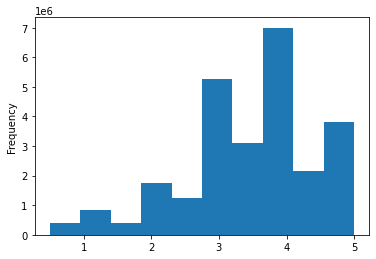

In [58]:
#Reasonability Checks on Ratings Data
#---------------------------------------------------

#looking at ratings data overall with datatypes
ratings.info(null_counts=True) #had to use null_counts=True because of so many rows in dataframe

#converting timestamp column to a datetime from unix time
ratings["timestamp"]=pd.to_datetime(ratings["timestamp"], unit="s")

#looking at statistics of actual ratings to make sure they look reasonable
pd.options.display.float_format = '{:20,.2f}'.format #changes output formatting
ratings["rating"].plot(kind="hist")
ratings["rating"].describe() #count, mean, std, min, med, quartiles, max

